# Labolatorium 7

## Dekompozycja spektralna

---
### Przydatne funkcje NumPy
- `numpy.linalg.eig`

---
### Przydatne importy

In [14]:
import numpy as np
from numpy import linalg as ln
import time
import matplotlib.pyplot as plt

---
### Metoda potęgowa

Napisz funkcje obliczającą metodą potęgową dominującą wartość własną (największą co do modułu) i odpowiadający jej wektor własny dla danej macierzy rzeczywistej symetrycznej. Sprawdź poprawność działania programu porównując własną implementację z wynikami funkcji bibliotecznej. Przedstaw na wykresie zależność czasu obliczeń od rozmiaru macierzy (rozmiar macierzy 100x100, 500x500, ...).

#### Funkcje pomocniczne

In [106]:
def get_symmetric_matrix(size):
    matrix = np.random.uniform(size=(size, size))
    return matrix + matrix.T - np.diag(matrix.diagonal())

def get_np_eig(matrix):
    np_eig_values, np_eig_vectors = ln.eig(matrix)
    max_i = np.argmax(abs(np_eig_values))
    
    return np_eig_vectors[:,max_i], np_eig_values[max_i]

#### Główna funkcja

In [108]:
def power_method(matrix, max_iterations=100000,  eps=10**(-12)):
    n = matrix.shape[0]
    x = np.random.uniform(size=(n, 1))
    for k in range(max_iterations):
        y = matrix @ x
        tmp = y / ln.norm(y, ord=np.inf) # as advised in kincaid & cheney
        
        if ln.norm(x - tmp) < eps: # ||x_i - x_i+1|| < e - our result is x_i+1
            x = tmp
            break

        x = tmp
    
    return k, (x / ln.norm(x)), ln.norm(y, ord=np.inf)

#### Sprawdzenie poprawności wyników i czasów wykonania

In [109]:
def benchmark(size, method, method_name):
    matrix = get_symmetric_matrix(size)
    start = time.time()
    _, eig_vector, eig_value = method(matrix)
    end = time.time()
    power_method_time = end - start
    
    np_start = time.time()
    np_eig_vector, np_eig_value = get_np_eig(matrix)
    np_end = time.time()
    np_eig_time = np_end - np_start
    
    print(f"\n------------ size = {size} ----------\n")
    print(f"{method_name} took {power_method_time}s to execute and returned eig value: {round(eig_value, 4)}")
    print(f"numpy.linalg.eig method took {np_eig_time}s to execute and returned eig value: {round(np_eig_value, 4)}")

    return power_method_time, np_eig_time   

In [110]:
sizes = [100, 300, 500, 700, 1000, 1500]
times = np.array([ benchmark(n, power_method, "power method") for n in sizes])


------------ size = 100 ----------

power method took 0.006716728210449219s to execute and returned eig value: 98.1366
numpy.linalg.eig method took 0.014932394027709961s to execute and returned eig value: 98.1366

------------ size = 300 ----------

power method took 0.001463174819946289s to execute and returned eig value: 299.7288
numpy.linalg.eig method took 0.12365198135375977s to execute and returned eig value: 299.7288

------------ size = 500 ----------

power method took 0.0007801055908203125s to execute and returned eig value: 500.7714
numpy.linalg.eig method took 0.3312418460845947s to execute and returned eig value: 500.7714

------------ size = 700 ----------

power method took 0.0014317035675048828s to execute and returned eig value: 699.45
numpy.linalg.eig method took 0.7730212211608887s to execute and returned eig value: 699.45

------------ size = 1000 ----------

power method took 0.0032808780670166016s to execute and returned eig value: 999.3369
numpy.linalg.eig metho

#### Przedstawienie wyników na wykresie

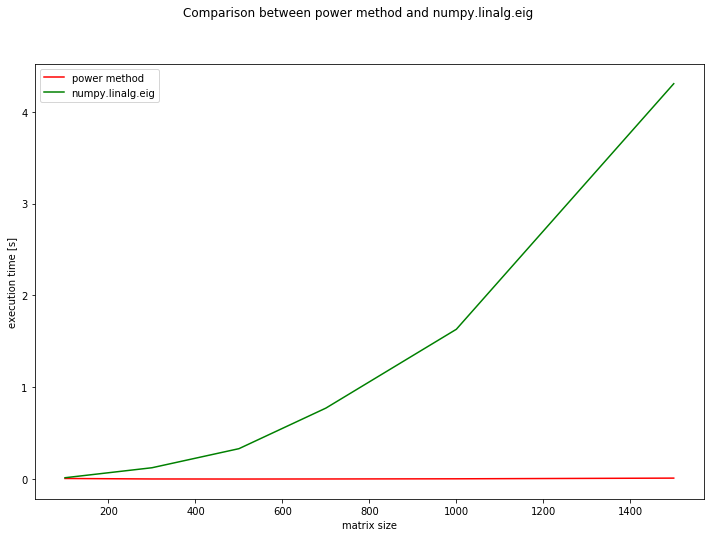

In [111]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,8))
fig.suptitle("Comparison between power method and numpy.linalg.eig")
ax1.plot(sizes, times[:, 0], 'r',label='power method')
ax1.plot(sizes, times[:, 1], 'g', label='numpy.linalg.eig')
ax1.legend()
ax1.set_xlabel("matrix size")
ax1.set_ylabel("execution time [s]")
plt.show()

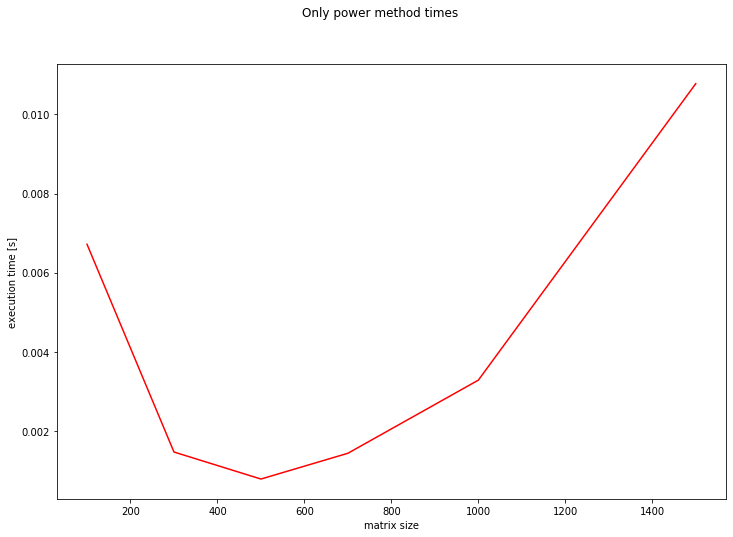

In [112]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,8))
fig.suptitle("Only power method times")
ax1.plot(sizes, times[:, 0], 'r')
ax1.set_xlabel("matrix size")
ax1.set_ylabel("execution time [s]")
plt.show()

Udało nam się uzyskać lepsze wyniki czasowe od funkcji bibliotecznej. Wynika to prawdopodobnie z tego, że metoda potęgowa ma pewne ograniczenia i nie działa zawsze, a funkcja biblioteczna jest przygotowana na różne przypadki macierzy. W przypadku losowych macierzy (nie symetrycznych) możliwe, że wyniki byłyby zupełnie inne (metoda potęgowa mogłaby w ogólnie nie zadziałać).

---
### Odwrotna metoda potęgowa

#### Sprawdzenie poprawności wyników i czasów wykonania